# Install dependencies

In [45]:
%pip install torch gensim datasets nltk


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Import dependencies

In [46]:
import os
import json
import nltk
nltk.download("all")

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from datasets import load_dataset
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from gensim.downloader import load as load_word2vec

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is alread

# Part 0. Dataset Preparation

In [47]:
# Part 0: Dataset Preparation
# Loading the Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
print(f"Size of training set: {train_dataset.num_rows} sentences")
print(f"Size of validation set: {validation_dataset.num_rows} sentences")
print(f"Size of test set: {test_dataset.num_rows} sentences")

Size of training set: 8530 sentences
Size of validation set: 1066 sentences
Size of test set: 1066 sentences


In [50]:
print(f"Sample sentence from train dataset: {test_dataset[0]['text']}")
print(f"Label: {'Positive' if test_dataset[0]['label'] == 1 else 'Negative'}")

Sample sentence from train dataset: lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .
Label: Positive


# Part 1: Preparing Word Embeddings

## Question 1(a): What is the size of the vocabulary formed from your training data?

In [51]:
# Tokenize each sentence in the training set
tokenized_texts = [word_tokenize(text["text"].lower()) for text in train_dataset]
print(f"Sample tokens from a sentence: {tokenized_texts[0]}")

# Flatten all tokens to create the vocabulary
all_tokens = [token for sentence in tokenized_texts for token in sentence]

# Create a vocabulary with special tokens for padding and unknown words
vocab = {"<PAD>": 0, "<UNK>": 1}
for token in all_tokens:
    if token not in vocab:
        vocab[token] = len(vocab)

vocab_size = len(vocab)

print(f"Number of tokens in all sentences: {len(all_tokens)}")
print(f"Size of the vocabulary including PADDING and UNKNOWN tokens: {vocab_size}")
print(f"Size of the vocabulary (excluding special tokens): {vocab_size - 2}")

Sample tokens from a sentence: ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', '``', 'conan', '``', 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean-claud', 'van', 'damme', 'or', 'steven', 'segal', '.']
Number of tokens in all sentences: 183968
Size of the vocabulary including PADDING and UNKNOWN tokens: 18031
Size of the vocabulary (excluding special tokens): 18029


## Question 1(b): How many OOV (out-of-vocabulary) words exist in your training data?

In [52]:
# Load pretrained Word2Vec embeddings
word2vec_path = f"{os.getcwd()}/word2vec.kv"
if os.path.isfile(word2vec_path):
    word2vec = KeyedVectors.load("./word2vec.kv")
else:
    word2vec = load_word2vec('word2vec-google-news-300')
    word2vec.save("word2vec.kv")

embedding_dim = word2vec.vector_size
print(f"Embedding dimensions: {embedding_dim}")

Embedding dimensions: 300


In [53]:
mean = np.mean(word2vec.vectors, axis=0)
std = np.std(word2vec.vectors, axis=0)

## Question 1(c): Implement a strategy to mitigate OOV words

In [54]:
# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
oov_count = 0

# Strategy: Randomly initialize OOV word embeddings with mean and std of pretrained embeddings
for word, index in vocab.items():
    if word in word2vec:
        embedding_matrix[index] = word2vec[word]
    else:
        # Handle OOV words with random initialization
        oov_count += 1
        embedding_matrix[index] = np.random.normal(
            loc=mean, scale=std, size=(embedding_dim,)
        )

print(f"Sample embeddings of a word: {embedding_matrix[index]}")
print(f"Number of out-of-vocabulary words: {oov_count - 2}") 
print(f"Sample embeddings of an unknown word: {embedding_matrix[vocab.get('<UNK>')]}")

Sample embeddings of a word: [ 2.30468750e-01 -1.02539062e-02  1.08886719e-01 -2.01171875e-01
  5.32226562e-02 -2.91748047e-02  4.68750000e-02  3.47900391e-03
  1.88476562e-01  3.94531250e-01 -8.36181641e-03 -2.08984375e-01
 -6.39648438e-02 -6.39648438e-02  6.62231445e-03  3.30078125e-01
  1.00585938e-01  3.10546875e-01  1.71875000e-01 -4.78515625e-01
  2.46047974e-04  9.81445312e-02  2.28515625e-01 -2.81250000e-01
  6.98242188e-02 -6.29882812e-02  1.91406250e-01  1.34765625e-01
  4.32128906e-02  5.03906250e-01 -2.09960938e-02 -1.01074219e-01
  2.69775391e-02  8.83789062e-02 -1.78710938e-01  6.15234375e-02
  7.37304688e-02 -4.37011719e-02  3.51562500e-02  5.29785156e-02
  4.92187500e-01  7.91015625e-02  9.66796875e-02  6.80541992e-03
 -1.01562500e-01  1.56250000e-01 -1.59179688e-01  2.04101562e-01
  2.02148438e-01 -1.04980469e-01  1.04980469e-01  1.71875000e-01
 -1.09863281e-01  1.14257812e-01 -1.37695312e-01  1.69921875e-01
 -8.01086426e-04 -1.74804688e-01  2.71484375e-01 -8.42285156e

# Part 2: Model Training & Evaluation - RNN


In [55]:
# Creating the dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        token_indices = self.__tokenizer(text, self.max_len)
        return torch.tensor(token_indices, dtype=torch.long), torch.tensor(
            label, dtype=torch.long
        )

    def __tokenizer(self, sentence, max_len):
        tokens = word_tokenize(sentence.lower())
        token_indices = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
        token_indices = token_indices[:max_len]
        padded_tokens = token_indices + [vocab["<PAD>"]] * (
            max_len - len(token_indices)
        )
        return padded_tokens

In [56]:
class RNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, freeze_embeddings, pooling):
        super(RNNModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=vocab.get("<PAD>"),
            freeze=freeze_embeddings,  # Freeze or unfreeze embeddings
        )

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.pooling = pooling  # 'max', 'average', or 'last'

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_output, hidden = self.rnn(embedded)

        if self.pooling == 'mask_max':
            # Max pooling over the RNN outputs
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            rnn_output = rnn_output.masked_fill(~mask, float('-inf'))
            pooled, _ = torch.max(rnn_output, dim=1)
        elif self.pooling == 'mask_average':
            # Average pooling over the RNN outputs
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            rnn_output = rnn_output * mask
            summed = rnn_output.sum(dim=1)
            valid_counts = mask.sum(dim=1)
            valid_counts = valid_counts.clamp(min=1)
            pooled = summed / valid_counts
        elif self.pooling == 'last':
            # Use the last hidden state
            pooled = hidden.squeeze(0)
        else:
            raise ValueError("Invalid pooling type. Choose from 'max', 'average', 'last'.")

        output = self.batch_norm(pooled)
        output = self.dropout(output)
        output = self.fc(output)

        return output

In [57]:
# Prepare the datasets
max_length = max(len(item) for item in tokenized_texts)
train_data = TextDataset(
    [item["text"] for item in train_dataset],
    [item["label"] for item in train_dataset],
    max_length,
)

valid_data = TextDataset(
    [item["text"] for item in validation_dataset],
    [item["label"] for item in validation_dataset],
    max_length,
)

test_data = TextDataset(
    [item["text"] for item in test_dataset],
    [item["label"] for item in test_dataset],
    max_length,
)

In [58]:
# Functions for training and evaluation
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_train_loss = 0
    total_correct_train = 0

    for texts, labels in data_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1
        )  # Apply gradient clipping to prevent exploding gradients
        optimizer.step()

        total_train_loss += loss.item()
        total_correct_train += (outputs.argmax(1) == labels).sum().item()
    train_loss = total_train_loss / len(data_loader)
    train_acc = total_correct_train / len(data_loader.dataset)
    return train_loss, train_acc


def evaluate_epoch(model, data_loader, criterion):
    model.eval()
    total_loss_val = 0
    total_correct_val = 0

    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss_val += loss.item()
            total_correct_val += (outputs.argmax(1) == labels).sum().item()
    val_loss = total_loss_val / len(data_loader)
    val_acc = total_correct_val / len(data_loader.dataset)
    return val_loss, val_acc

def draw_plot(train_losses, train_accuracies, val_losses, val_accuracies, title):
    num_epochs = len(train_losses)  # Number of epochs
    # Plotting train and validation loss
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label=f'Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label=f'Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label=f'Train Accuracy', marker='o')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label=f'Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Display the plots
    plt.show()

In [59]:
# Hyperparameters to tune
batch_sizes = [32, 64]
learning_rates = [0.001, 0.0005]
hidden_dims = [128, 256]
patiences = [3, 5]
pooling_methods = ['mask_max', 'mask_average', 'last']
freeze_options = [True, False]  # For frozen and unfrozen embeddings

In [60]:
best_val_acc = 0.0
best_config = {}
results = []

# Loop over different configurations to find the best one
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for hidden_dim in hidden_dims:
            for patience in patiences:
                for pooling in pooling_methods:
                    for freeze_embeddings in freeze_options:
                        # Prepare data loaders
                        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                        val_loader = DataLoader(valid_data, batch_size=batch_size)
                        test_loader = DataLoader(test_data, batch_size=batch_size)

                        # Initialize the model
                        model = RNNModel(embedding_matrix, hidden_dim, output_dim=2,
                                         freeze_embeddings=freeze_embeddings, pooling=pooling)
                        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                        criterion = nn.CrossEntropyLoss()
                        model.to(device)

                        # Training the model with early stopping
                        num_epochs = 50
                        early_stopping_count = 0
                        best_model_val_acc = 0.0

                        train_losses = []
                        train_accuracies = []
                        val_losses = []
                        val_accuracies = []

                        for epoch in range(num_epochs):
                            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
                            train_losses.append(train_loss)
                            train_accuracies.append(train_acc)
                            val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)
                            val_losses.append(val_loss)
                            val_accuracies.append(val_acc)

                            print(f'Epoch [{epoch + 1}/{num_epochs}] - Pooling: {pooling}, Freeze: {freeze_embeddings}')
                            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

                            # Early stopping based on validation accuracy
                            if val_acc > best_model_val_acc:
                                best_model_val_acc = val_acc
                                torch.save(model.state_dict(), 'best_model_temp.pth')
                                early_stopping_count = 0
                            else:
                                early_stopping_count += 1
                                if early_stopping_count >= patience:
                                    print("Early stopping as validation accuracy is not improving")
                                    break

                        # Load the best model for this configuration
                        model.load_state_dict(torch.load('best_model_temp.pth'))

                        # Evaluate on test set
                        test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)
                        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

                        # Record the results
                        config = {
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'hidden_dim': hidden_dim,
                            'patience': patience,
                            'pooling': pooling,
                            'freeze_embeddings': freeze_embeddings,
                            'num_epochs': epoch + 1  # Number of epochs trained
                        }

                        results.append({
                            'config': config,
                            'val_acc': best_model_val_acc,
                            'test_acc': test_acc,
                            'train_losses': train_losses,
                            'train_accuracies': train_accuracies,
                            'val_losses': val_losses,
                            'val_accuracies': val_accuracies
                        })

                        # Update the best model if needed
                        if val_acc > best_val_acc:
                            best_val_acc = val_acc
                            best_config = config
                            torch.save(model.state_dict(), 'Final - P2 - Word2vec - Config.pth')
                            best_train_losses = train_losses
                            best_train_accuracies = train_accuracies
                            best_val_losses = val_losses
                            best_val_accuracies = val_accuracies

Epoch [1/50] - Pooling: mask_max, Freeze: True
Train Loss: 0.5660, Train Acc: 0.7091, Val Loss: 0.5041, Val Acc: 0.7458
Epoch [2/50] - Pooling: mask_max, Freeze: True
Train Loss: 0.4504, Train Acc: 0.7883, Val Loss: 0.4732, Val Acc: 0.7824
Epoch [3/50] - Pooling: mask_max, Freeze: True
Train Loss: 0.4188, Train Acc: 0.8090, Val Loss: 0.5540, Val Acc: 0.7242
Epoch [4/50] - Pooling: mask_max, Freeze: True
Train Loss: 0.3842, Train Acc: 0.8278, Val Loss: 0.4648, Val Acc: 0.7814
Epoch [5/50] - Pooling: mask_max, Freeze: True
Train Loss: 0.3423, Train Acc: 0.8489, Val Loss: 0.4757, Val Acc: 0.7842
Epoch [6/50] - Pooling: mask_max, Freeze: True
Train Loss: 0.3324, Train Acc: 0.8558, Val Loss: 0.4844, Val Acc: 0.7852
Epoch [7/50] - Pooling: mask_max, Freeze: True
Train Loss: 0.2941, Train Acc: 0.8764, Val Loss: 0.5564, Val Acc: 0.7645
Epoch [8/50] - Pooling: mask_max, Freeze: True
Train Loss: 0.2760, Train Acc: 0.8829, Val Loss: 0.5336, Val Acc: 0.7777
Epoch [9/50] - Pooling: mask_max, Freeze

/var/folders/0f/9lfqv2_d3dd8rwwcwl7x4r000000gr/T/ipykernel_22051/1206234153.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

Epoch [1/50] - Pooling: mask_max, Freeze: False
Train Loss: 0.5321, Train Acc: 0.7333, Val Loss: 0.4850, Val Acc: 0.7636
Epoch [2/50] - Pooling: mask_max, Freeze: False
Train Loss: 0.3152, Train Acc: 0.8653, Val Loss: 0.5799, Val Acc: 0.7617
Epoch [3/50] - Pooling: mask_max, Freeze: False
Train Loss: 0.1755, Train Acc: 0.9349, Val Loss: 0.7618, Val Acc: 0.7477
Epoch [4/50] - Pooling: mask_max, Freeze: False
Train Loss: 0.1169, Train Acc: 0.9580, Val Loss: 0.8367, Val Acc: 0.7495
Early stopping as validation accuracy is not improving
Test Loss: 0.4387, Test Acc: 0.7889
Epoch [1/50] - Pooling: mask_average, Freeze: True
Train Loss: 0.5379, Train Acc: 0.7285, Val Loss: 0.5286, Val Acc: 0.7411
Epoch [2/50] - Pooling: mask_average, Freeze: True
Train Loss: 0.4913, Train Acc: 0.7646, Val Loss: 0.5136, Val Acc: 0.7514
Epoch [3/50] - Pooling: mask_average, Freeze: True
Train Loss: 0.4842, Train Acc: 0.7674, Val Loss: 0.4944, Val Acc: 0.7570
Epoch [4/50] - Pooling: mask_average, Freeze: True
Tr


Best Configuration:
{'batch_size': 64, 'learning_rate': 0.001, 'hidden_dim': 256, 'patience': 5, 'pooling': 'mask_max', 'freeze_embeddings': True, 'num_epochs': 10}
Validation Accuracy: 0.7842


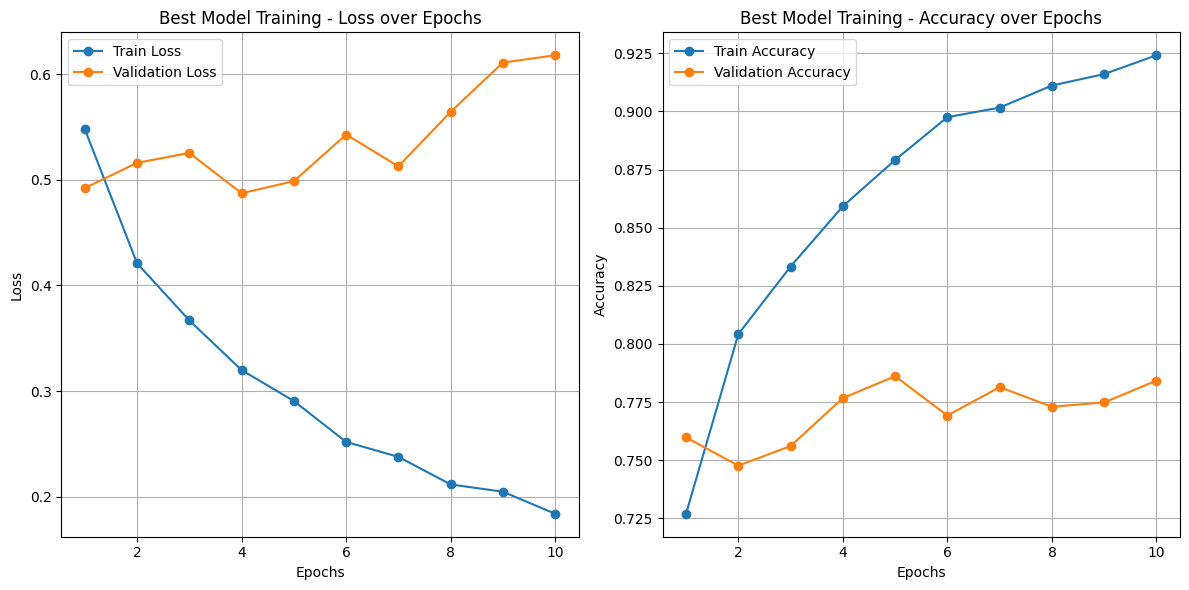

In [61]:
# After all configurations, report the best one
print("\nBest Configuration:")
print(best_config)
print(f"Validation Accuracy: {best_val_acc:.4f}")

# Plot the training and validation curves for the best model
draw_plot(best_train_losses, best_train_accuracies, best_val_losses, best_val_accuracies, "Best Model Training")

In [62]:
# Load the best model and evaluate on the test set
model = RNNModel(
    embedding_matrix,
    best_config["hidden_dim"],
    output_dim=2,
    freeze_embeddings=freeze_embeddings,
    pooling=best_config["pooling"],
)
model.load_state_dict(torch.load("Final - P2 - Word2vec - Config.pth"))
model.to(device)
test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)
print(f"Best Model Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

/var/folders/0f/9lfqv2_d3dd8rwwcwl7x4r000000gr/T/ipykernel_22051/59094277.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Final - P2 - 

Best Model Test Loss: 0.4632, Test Acc: 0.7786


In [63]:
# Question 2(a): Report the final configuration of your best model
print("\nQuestion 2(a): Final Configuration of the Best Model")
print(f"Number of Training Epochs: {best_config['num_epochs']}")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Optimizer: Adam")
print(f"Batch Size: {best_config['batch_size']}")
print(f"Hidden Dimension: {best_config['hidden_dim']}")
print(f"Patience: {best_config['patience']}")
print(f"Pooling Method: {best_config['pooling']}")
print(f"Freeze Embeddings: {best_config['freeze_embeddings']}")


Question 2(a): Final Configuration of the Best Model
Number of Training Epochs: 10
Learning Rate: 0.001
Optimizer: Adam
Batch Size: 64
Hidden Dimension: 256
Patience: 5
Pooling Method: mask_max
Freeze Embeddings: True


In [69]:
# Question 2(b): Report the accuracy score on the test set, and validation set for each epoch
print("\nQuestion 2(b): Accuracy Scores")
print("Validation Accuracy for each epoch:")
for epoch, val_acc in enumerate(best_val_accuracies):
    print(f"[Epoch {epoch + 1}] Accuracy: {best_val_accuracies[epoch]:.4f}, Lost: {best_val_losses[epoch]:.4f}")
print(f"\nTest Accuracy of the Best Model: {test_acc:.4f}")


Question 2(b): Accuracy Scores
Validation Accuracy for each epoch:
[Epoch 1] Accuracy: 0.7598, Lost: 0.4922
[Epoch 2] Accuracy: 0.7477, Lost: 0.5161
[Epoch 3] Accuracy: 0.7561, Lost: 0.5255
[Epoch 4] Accuracy: 0.7767, Lost: 0.4873
[Epoch 5] Accuracy: 0.7861, Lost: 0.4987
[Epoch 6] Accuracy: 0.7692, Lost: 0.5429
[Epoch 7] Accuracy: 0.7814, Lost: 0.5128
[Epoch 8] Accuracy: 0.7730, Lost: 0.5644
[Epoch 9] Accuracy: 0.7749, Lost: 0.6110
[Epoch 10] Accuracy: 0.7842, Lost: 0.6179

Test Accuracy of the Best Model: 0.7786


In [83]:
# Question 2(c): Methods tried for deriving sentence representation and their accuracy scores
print("\nQuestion 2(c): Methods Tried for Sentence Representation")
pooling_methods_tried = set()
for result in results:
    pooling_methods_tried.add(result['config']['pooling'])

for pooling_method in pooling_methods_tried:
    method_results = [res for res in results if res['config']['pooling'] == pooling_method]
    best_result = max(method_results, key=lambda x: x['val_acc'])
    print(f"Pooling Method: {pooling_method}")
    print(f"Validation Loss: {best_result['val_losses'][-1]:.4f}")
    print(f"Validation Accuracy: {best_result['val_acc']:.4f}")
    print(f"Test Accuracy: {best_result['test_acc']:.4f}\n")


Question 2(c): Methods Tried for Sentence Representation
Pooling Method: mask_max
Validation Loss: 0.5174
Validation Accuracy: 0.7946
Test Accuracy: 0.7824

Pooling Method: mask_average
Validation Loss: 1.2279
Validation Accuracy: 0.7833
Test Accuracy: 0.8011

Pooling Method: last
Validation Loss: 0.9764
Validation Accuracy: 0.5019
Test Accuracy: 0.5009



In [66]:
with open("best_config.json", "w") as file:
    json.dump(best_config, file, indent=4)